## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

%matplotlib inline

## Helper Functions
Helper functions that was learned from leason!

In [2]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', channel='gray', thresh_min=0, thresh_max=255):
    if channel == 'gray':
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif channel == 'R':
        gray = img[:,:,0]
    elif channel == 'G':
        gray = img[:,:,1]
    elif channel == 'B':
        gray = img[:,:,2]
        
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

In [3]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, channel='gray', mag_thresh=(0, 255)):
    if channel == 'gray':
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif channel == 'R':
        gray = img[:,:,0]
    elif channel == 'G':
        gray = img[:,:,1]
    elif channel == 'B':
        gray = img[:,:,2]
        
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [4]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, channel='gray', thresh=(0, np.pi/2)):
    if channel == 'gray':
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    elif channel == 'R':
        gray = img[:,:,0]
    elif channel == 'G':
        gray = img[:,:,1]
    elif channel == 'B':
        gray = img[:,:,2]
        
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

In [5]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return binary_output

In [44]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (1,) * channel_count
    else:
        ignore_mask_color = 1
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

### Perspective Transform

In [32]:
# Define a function to perform a perspective transform
def perspect_transform(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

For simplicity, we choose four source and four destination points manually for perspective transformation. Actually, it is often not the best option. There are many other ways to select the points.

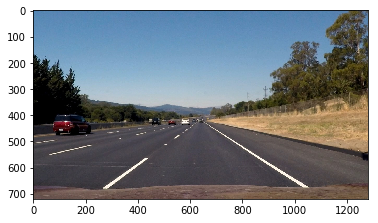

In [33]:
# Show test image in interactive window for choose four vertices for perspective transformation
%matplotlib qt

image = mpimg.imread('test_images/straight_lines2.jpg')

plt.imshow(image)
plt.show()

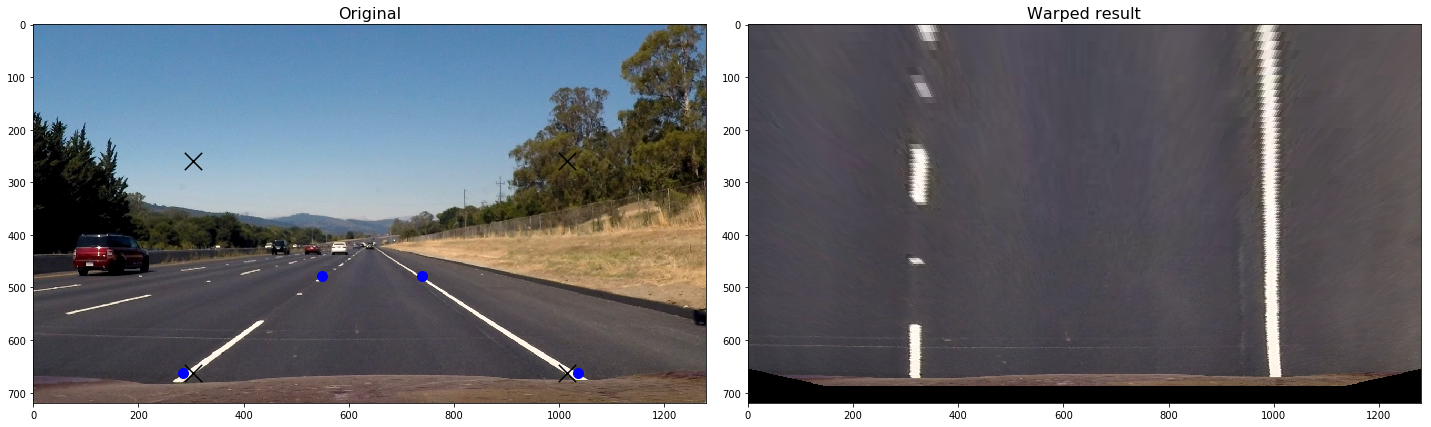

In [34]:
%matplotlib inline

src = np.float32([[739, 478], [1035 ,662],[284, 662], [549, 478]])
dsr = np.float32([[1035-20, 260], [1035-20, 662],[284+20, 662], [284+20, 260]])
#dsr = np.float32([[1035, 478], [1035 ,662],[284, 662], [284, 478]])

image = mpimg.imread('test_images/straight_lines2.jpg')
warped = perspect_transform(image, src, dsr)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()

ax1.imshow(image)
ax1.scatter(src[:,0], src[:,1], s=100, c='blue', marker='o')
ax1.scatter(dsr[:,0], dsr[:,1], s=300, c='black', marker='x')
ax1.set_title('Original', fontsize=16)

ax2.imshow(warped)
ax2.set_title('Warped result', fontsize=16)

plt.show()

## Finding the Lines

In [35]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [114]:
# nwindows - number of sliding windows
# margin   - width of the windows +/- margin
# minpix   - minimum number of pixels found to recenter window

def find_lanes_fullsearch(binary_warped, lane_lines, margin=100, nwindows=9, minpix=50):
    
    (lline, rline) = lane_lines # (left line, right line)
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    ## Create an output image to draw on and  visualize the result
    #out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        ## Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        #(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        #(0,255,0), 2)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    lline.allx = nonzerox[left_lane_inds]
    lline.ally = nonzeroy[left_lane_inds] 
    rline.allx = nonzerox[right_lane_inds]
    rline.ally = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    lline.current_fit = np.polyfit(lline.ally, lline.allx, 2)
    rline.current_fit = np.polyfit(rline.ally, rline.allx, 2)
    
    lline.detected = True
    rline.detected = True
    
    return lane_lines

In [115]:
# margin   - width of the windows +/- margin

def find_lanes_polyfit(binary_warped, lane_lines, margin=100):
    
    (lline, rline) = lane_lines # (left line, right line)

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_fit = lline.current_fit
    right_fit = rline.current_fit
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    lline.allx = nonzerox[left_lane_inds]
    lline.ally = nonzeroy[left_lane_inds] 
    rline.allx = nonzerox[right_lane_inds]
    rline.ally = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    lline.current_fit = np.polyfit(lline.ally, lline.allx, 2)
    rline.current_fit = np.polyfit(rline.ally, rline.allx, 2)
    
    return lane_lines


In [105]:
def polyfit_xyvals(left_fit, right_fit, shape_y):
    ploty = np.linspace(0, shape_y-1, shape_y )
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fitx, right_fitx, ploty

In [106]:
def fill_lane(warped, left_fitx, right_fitx, fity):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, fity]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, fity])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        
    return color_warp

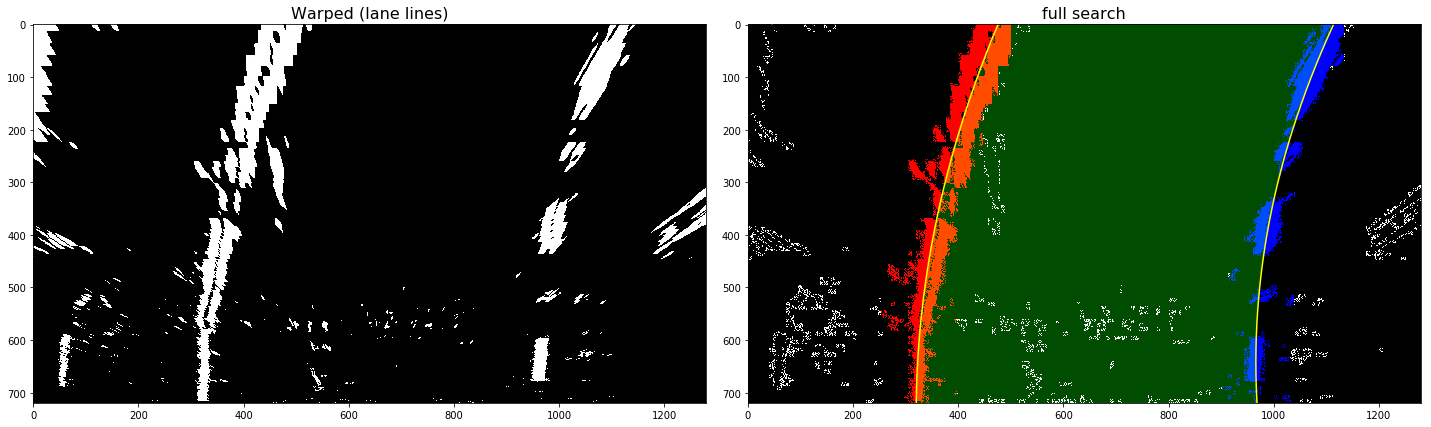

In [120]:
binary_warped = mpimg.imread('warped_example.jpg')

lane_lines = (Line(), Line()) # (left line, right line)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

margin = 70

(lline, rline) = find_lanes_fullsearch(binary_warped, lane_lines, margin)

# Generate x and y values for plotting
left_fitx, right_fitx, fity = polyfit_xyvals(lline.current_fit, rline.current_fit, binary_warped.shape[0])

out_img[lline.ally, lline.allx] = [255, 0, 0]
out_img[rline.ally, rline.allx] = [0, 0, 255]

# fill lane area
filled_lane = fill_lane(binary_warped, left_fitx, right_fitx, fity)
out_img = cv2.addWeighted(out_img, 1, filled_lane, 0.3, 0)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
f.tight_layout()

fontsize=16
ax1.imshow(binary_warped, cmap='gray')
ax1.set_title('Warped (lane lines)', fontsize=fontsize)

ax2.imshow(out_img)
ax2.plot(left_fitx, fity, color='yellow')
ax2.plot(right_fitx, fity, color='yellow')
ax2.set_title('full search', fontsize=fontsize)


plt.show()

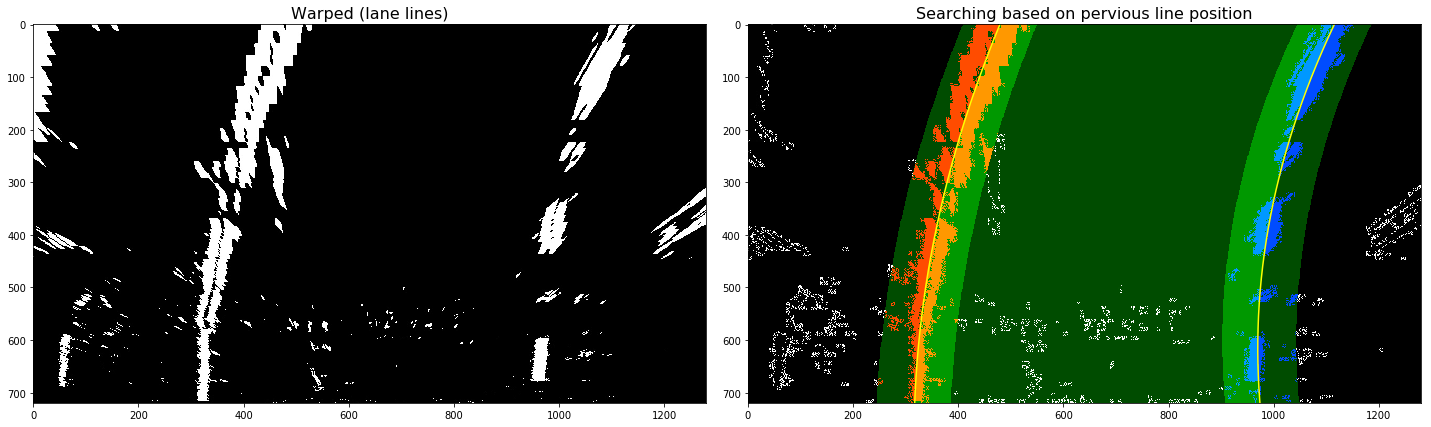

In [119]:
margin = 70

(lline, rline) = find_lanes_polyfit(binary_warped, lane_lines, margin)

# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)

out_img[lline.ally, lline.allx] = [255, 0, 0]
out_img[rline.ally, rline.allx] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_fit = lline.current_fit
right_fit = rline.current_fit
#
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

# Generate x and y values for plotting
left_fitx, right_fitx, ploty = polyfit_xyvals(lline.current_fit, rline.current_fit, binary_warped.shape[0])

# fill lane area
filled_lane = fill_lane(binary_warped, left_fitx, right_fitx, fity)
result = cv2.addWeighted(result, 1, filled_lane, 0.3, 0)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
f.tight_layout()

fontsize=16
ax1.imshow(binary_warped, cmap='gray')
ax1.set_title('Warped (lane lines)', fontsize=fontsize)

ax2.imshow(result)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
ax2.set_title('Searching based on pervious line position', fontsize=fontsize)

plt.show()

## Measuring Curvature & Position

In [147]:
# Define a function to caculate the radius of curvature and car position w.r.t center of lane
#
# Define conversions in x and y from pixels space to meters
# ym_per_pix = 30/720 # meters per pixel in y dimension
# xm_per_pix = 3.7/700 # meters per pixel in x dimension

def calc_curvature_n_pos(left_fitx, right_fitx, ploty, xm_per_pix = 3.7/700, ym_per_pix = 30/720):
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Calculate the car position w.r.t center of lane
    y_base = 720.0
    centerx_base = 640.0
    lline_base_pos = ((left_fit[0]*y_base**2 + left_fit[1]*y_base + left_fit[2]) - centerx_base) * xm_per_pix
    rline_base_pos = ((right_fit[0]*y_base**2 + right_fit[1]*y_base + right_fit[2]) - centerx_base) * xm_per_pix
    
    return left_curverad, right_curverad, lline_base_pos, rline_base_pos

In [159]:
left_curverad, right_curverad, lline_base_pos, rline_base_pos = calc_curvature_n_pos(left_fitx, right_fitx, ploty)
print('Radius of curvature:', left_curverad, 'm', right_curverad, 'm')
print('Left line base position:', int(lline_base_pos), 'm', 'Right line base position:', int(rline_base_pos), 'm')

Radius of curvature: 1391.65528774 m 786.132921607 m
Left line base position: -1 m Right line base position: 1 m


## Test Images
Build a pipeline to work on the images in the directory "test_images"

In [42]:
import os
testing_names = os.listdir("test_images/")
testing_names

['straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

## Build an Advanced Lane Finding Pipeline

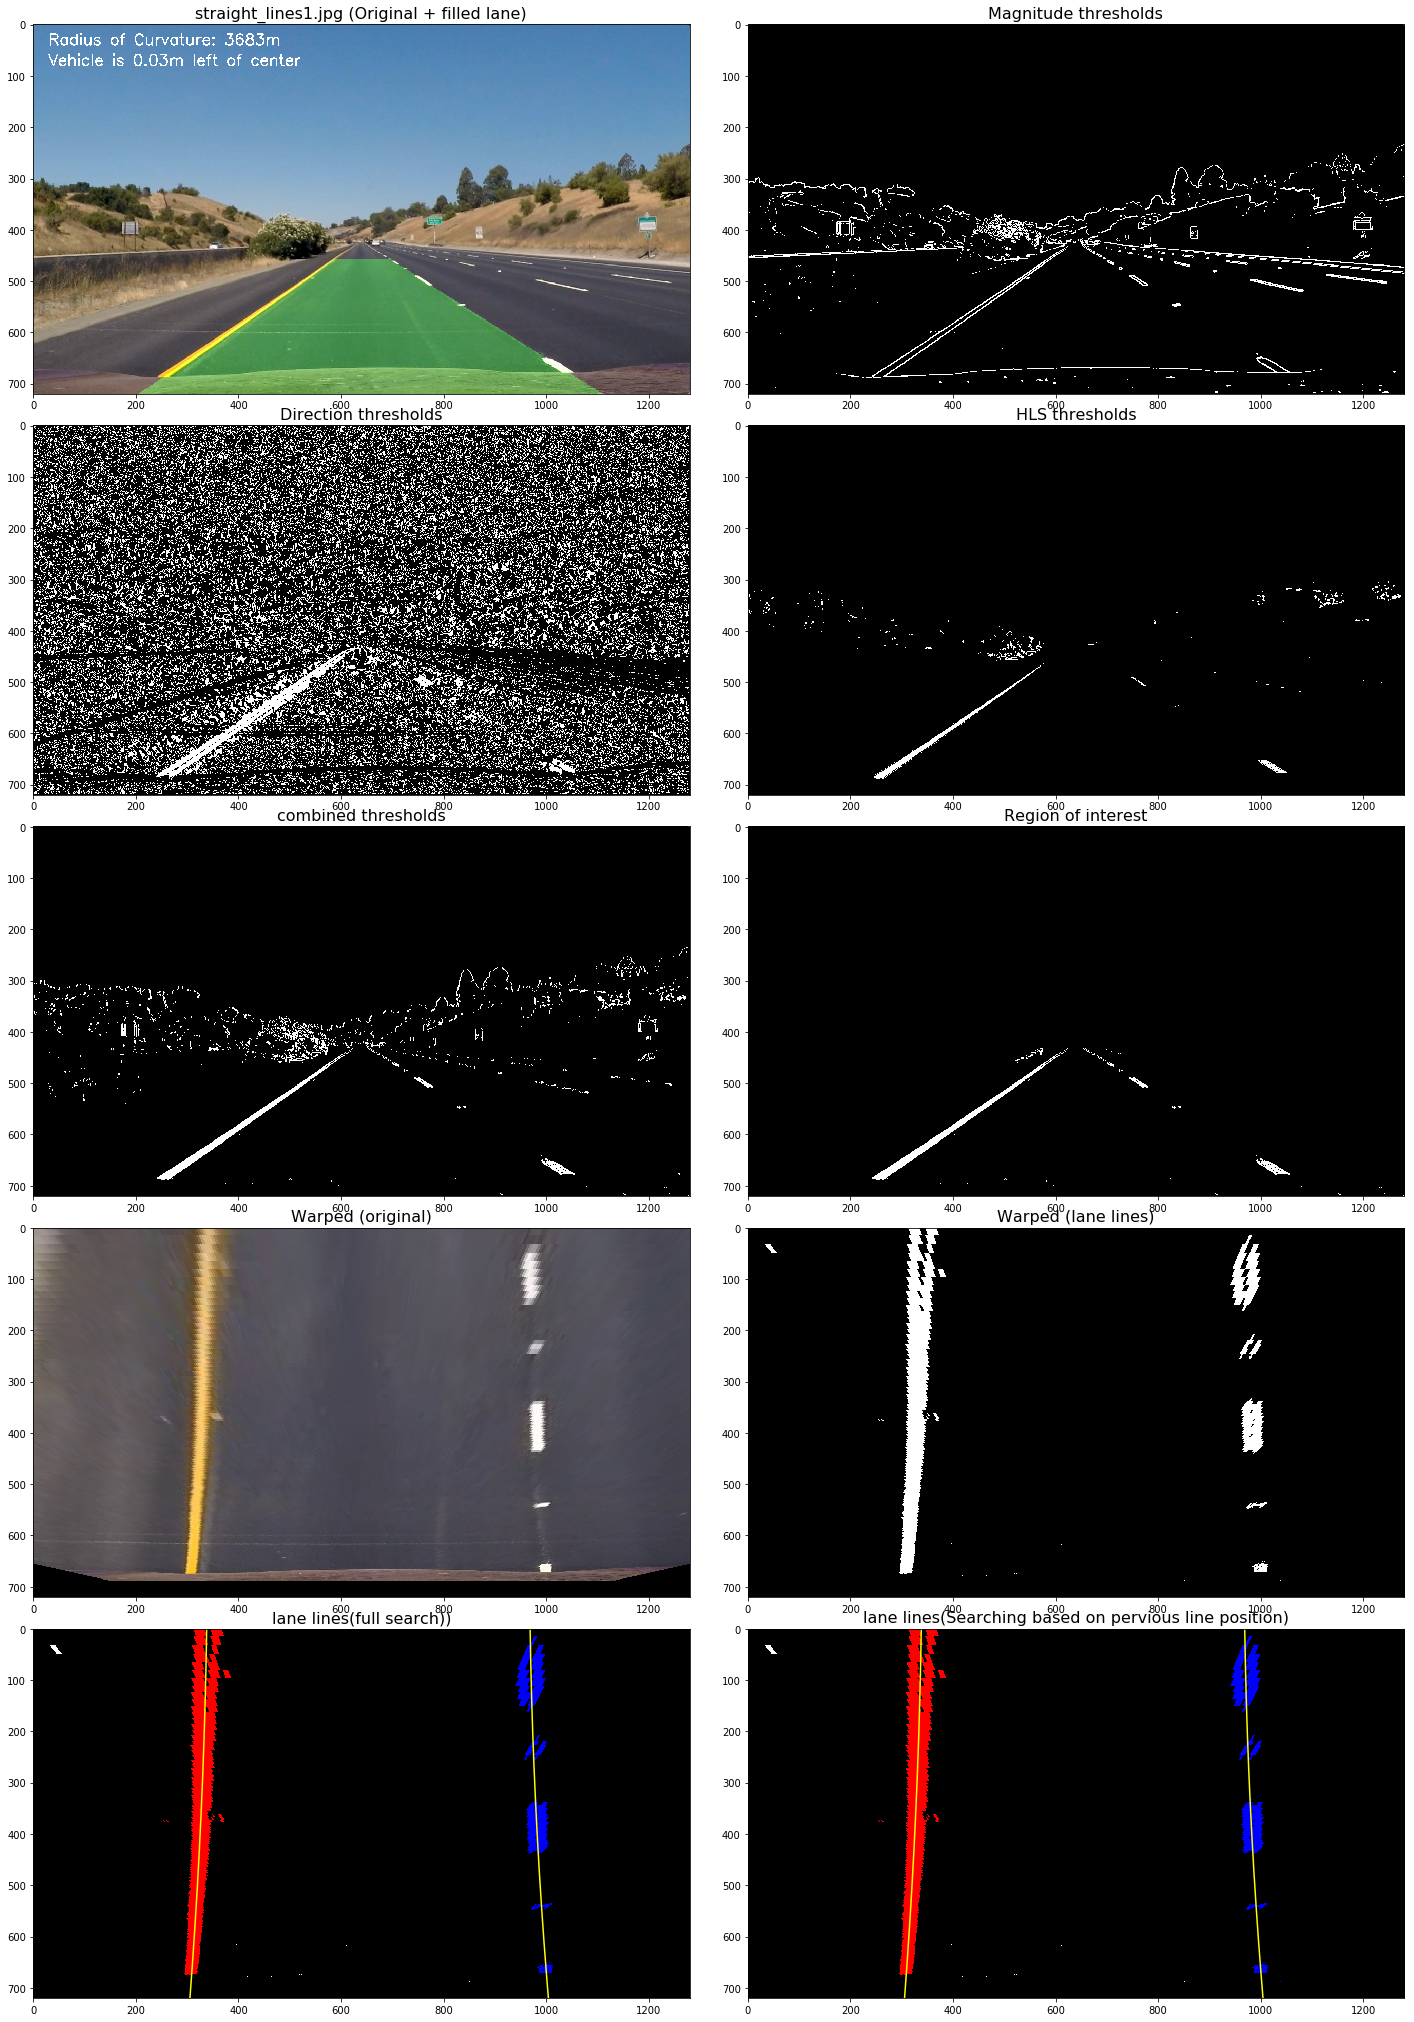

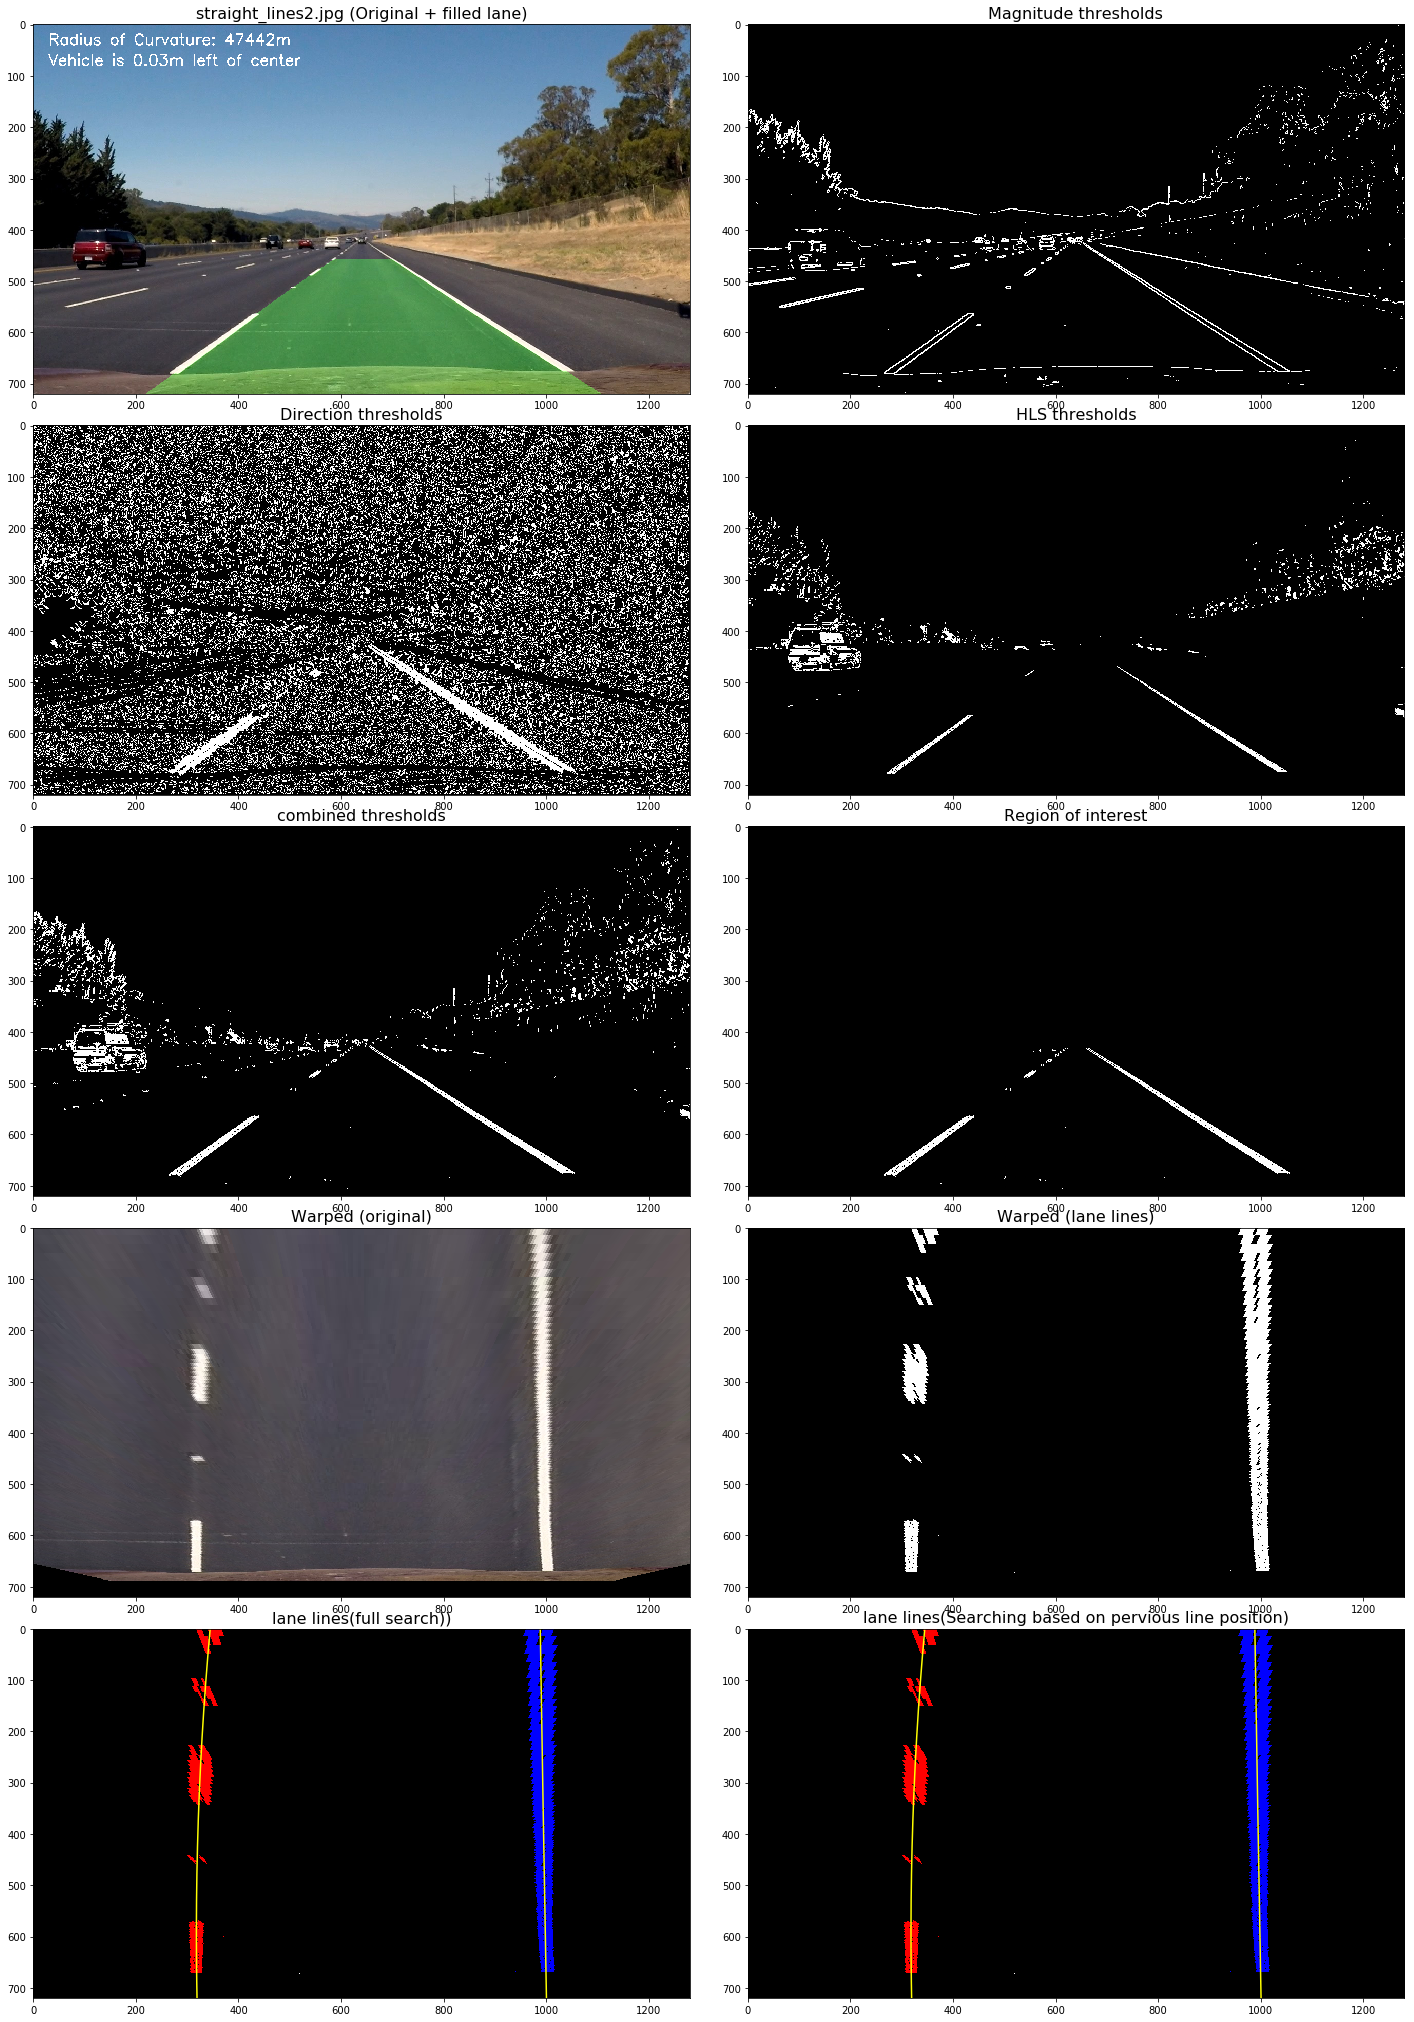

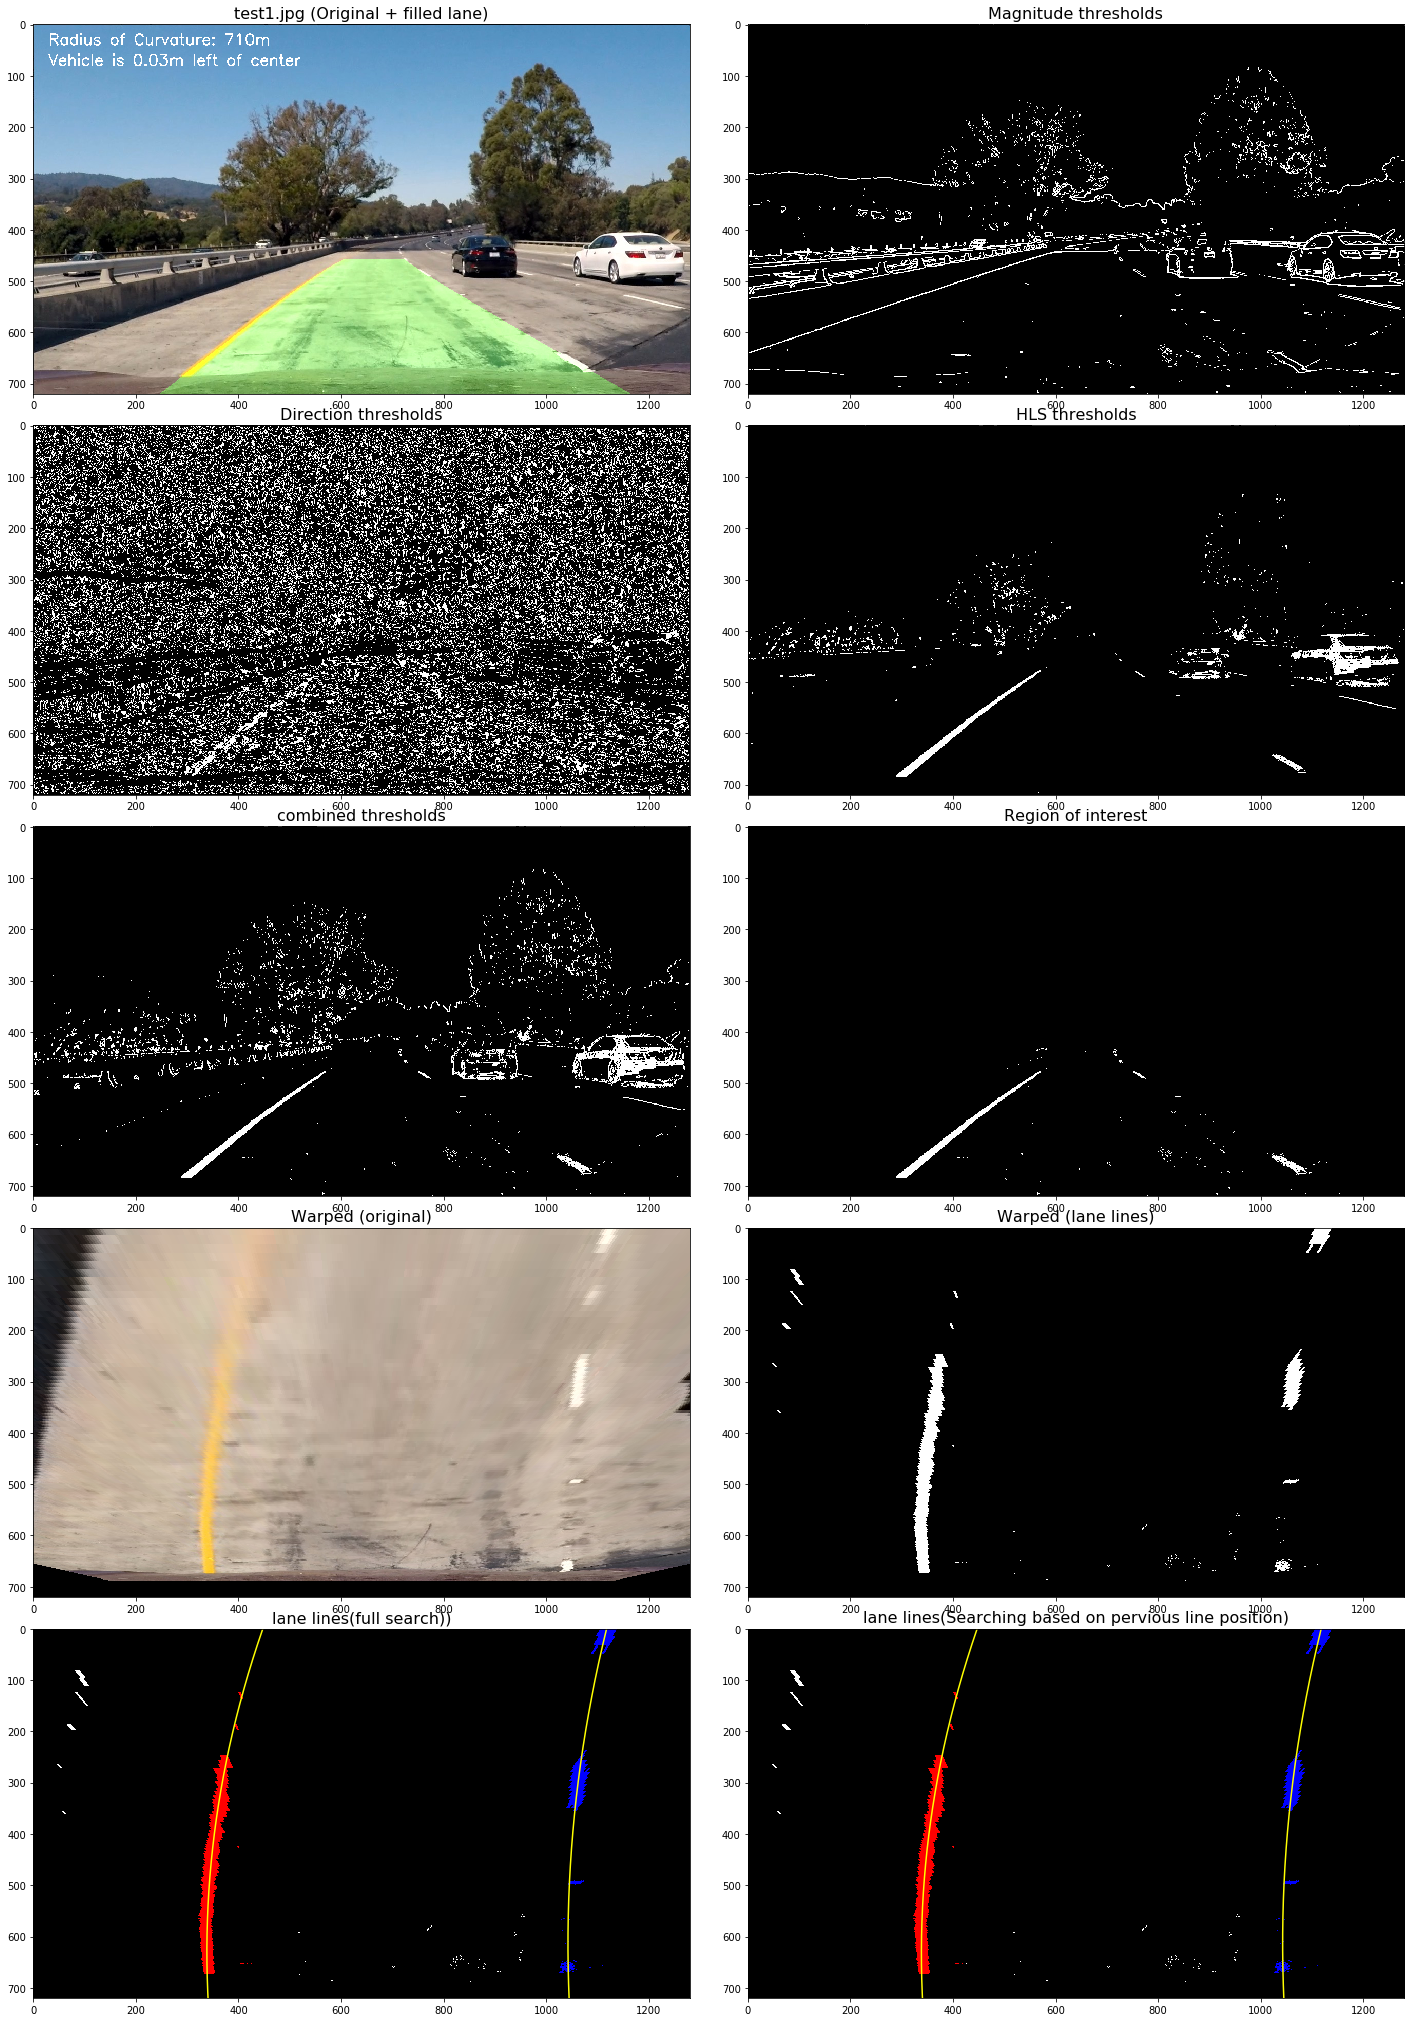

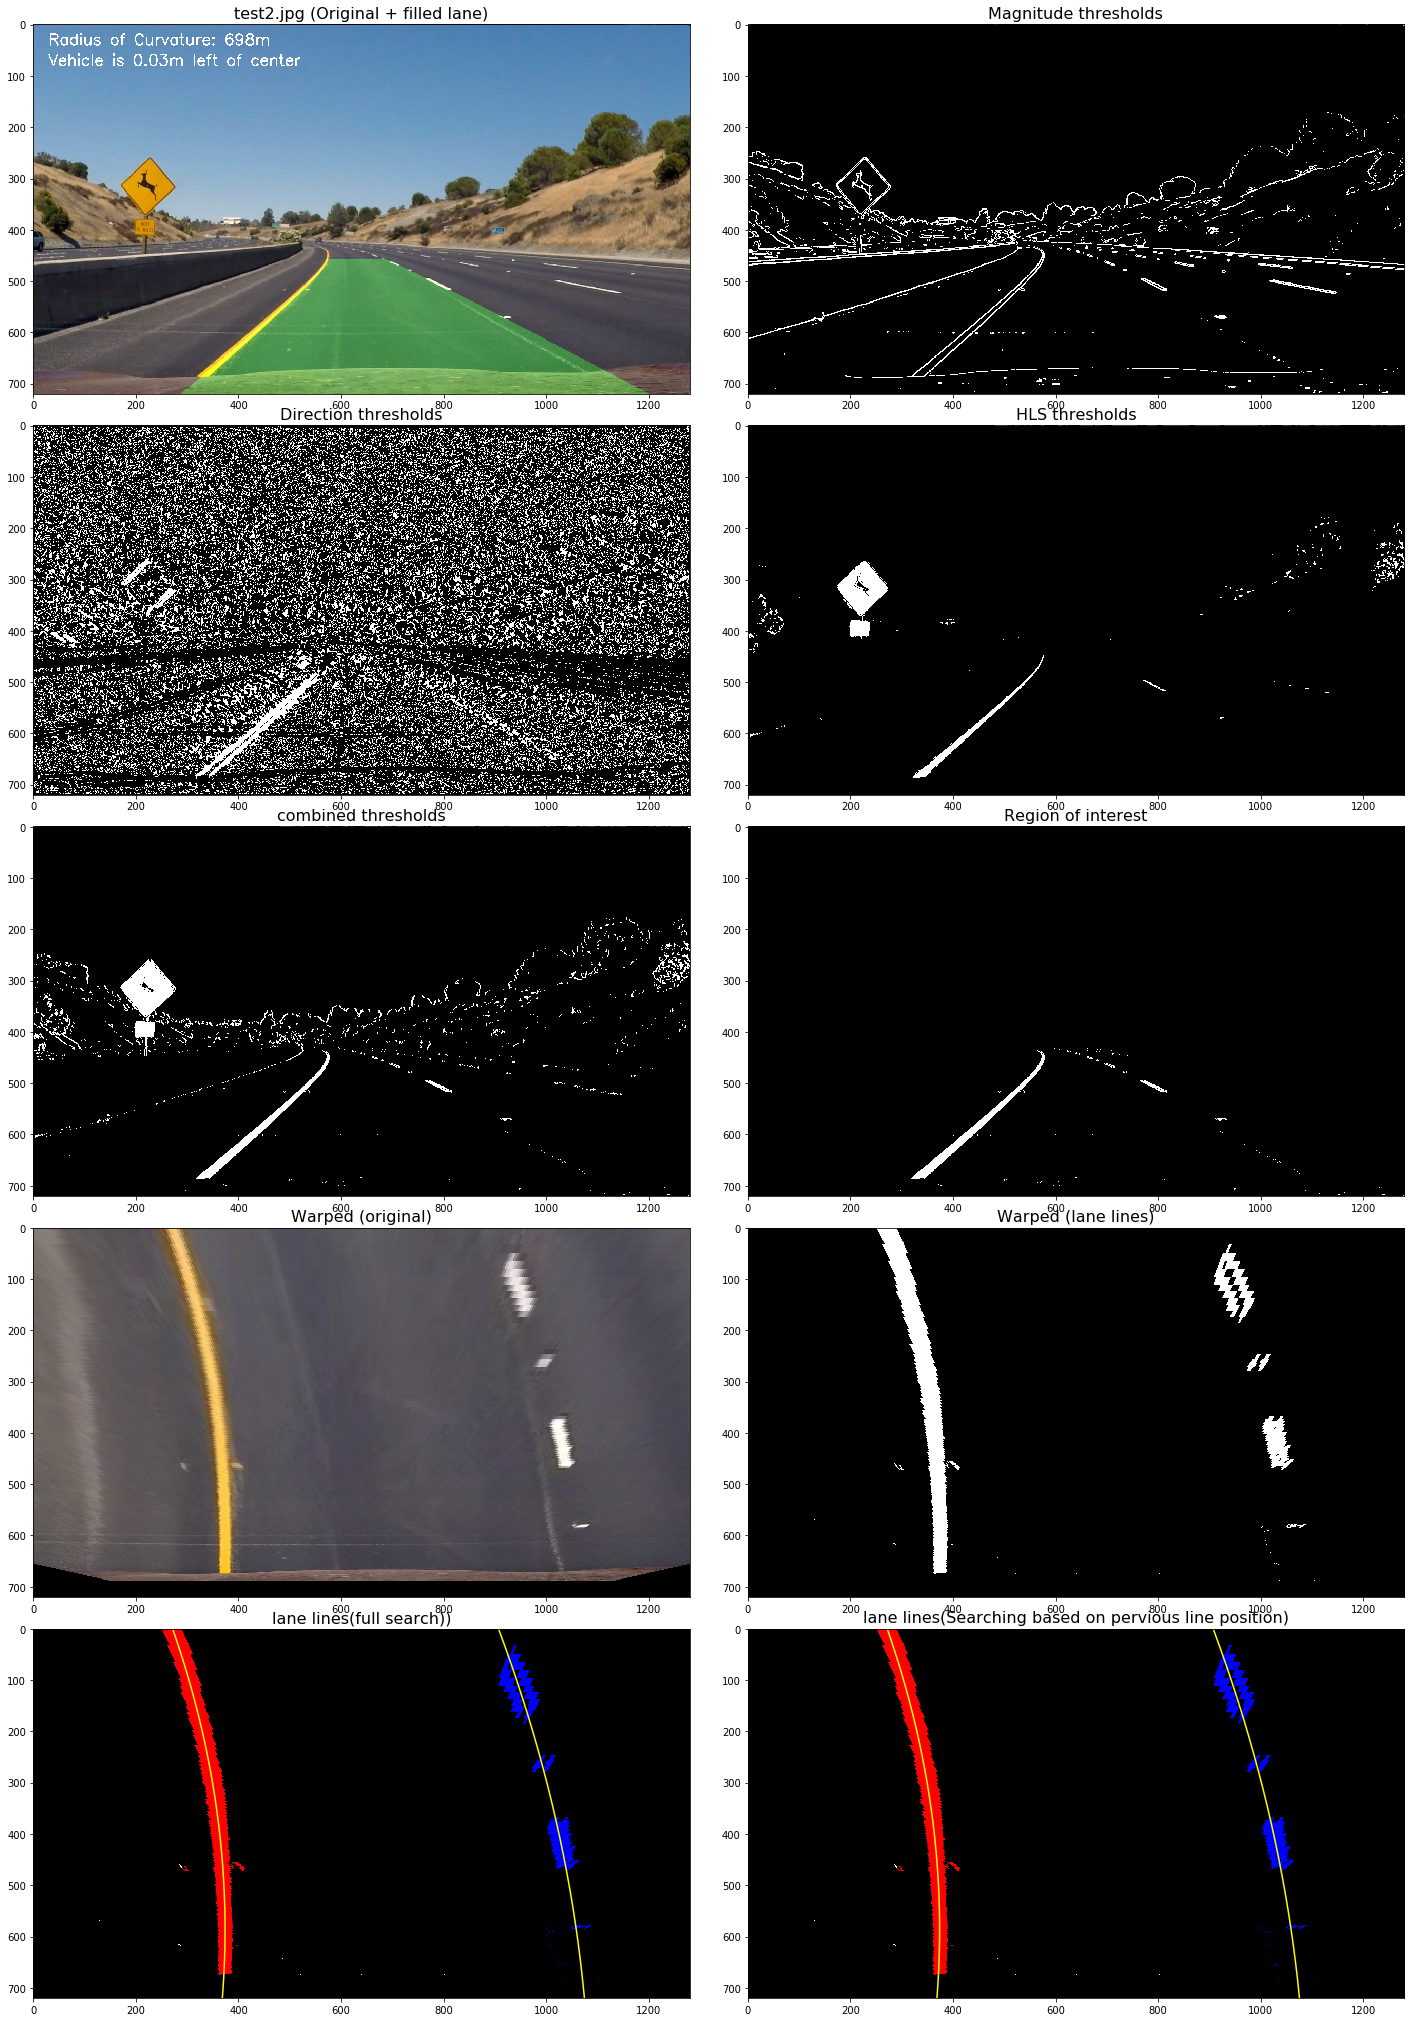

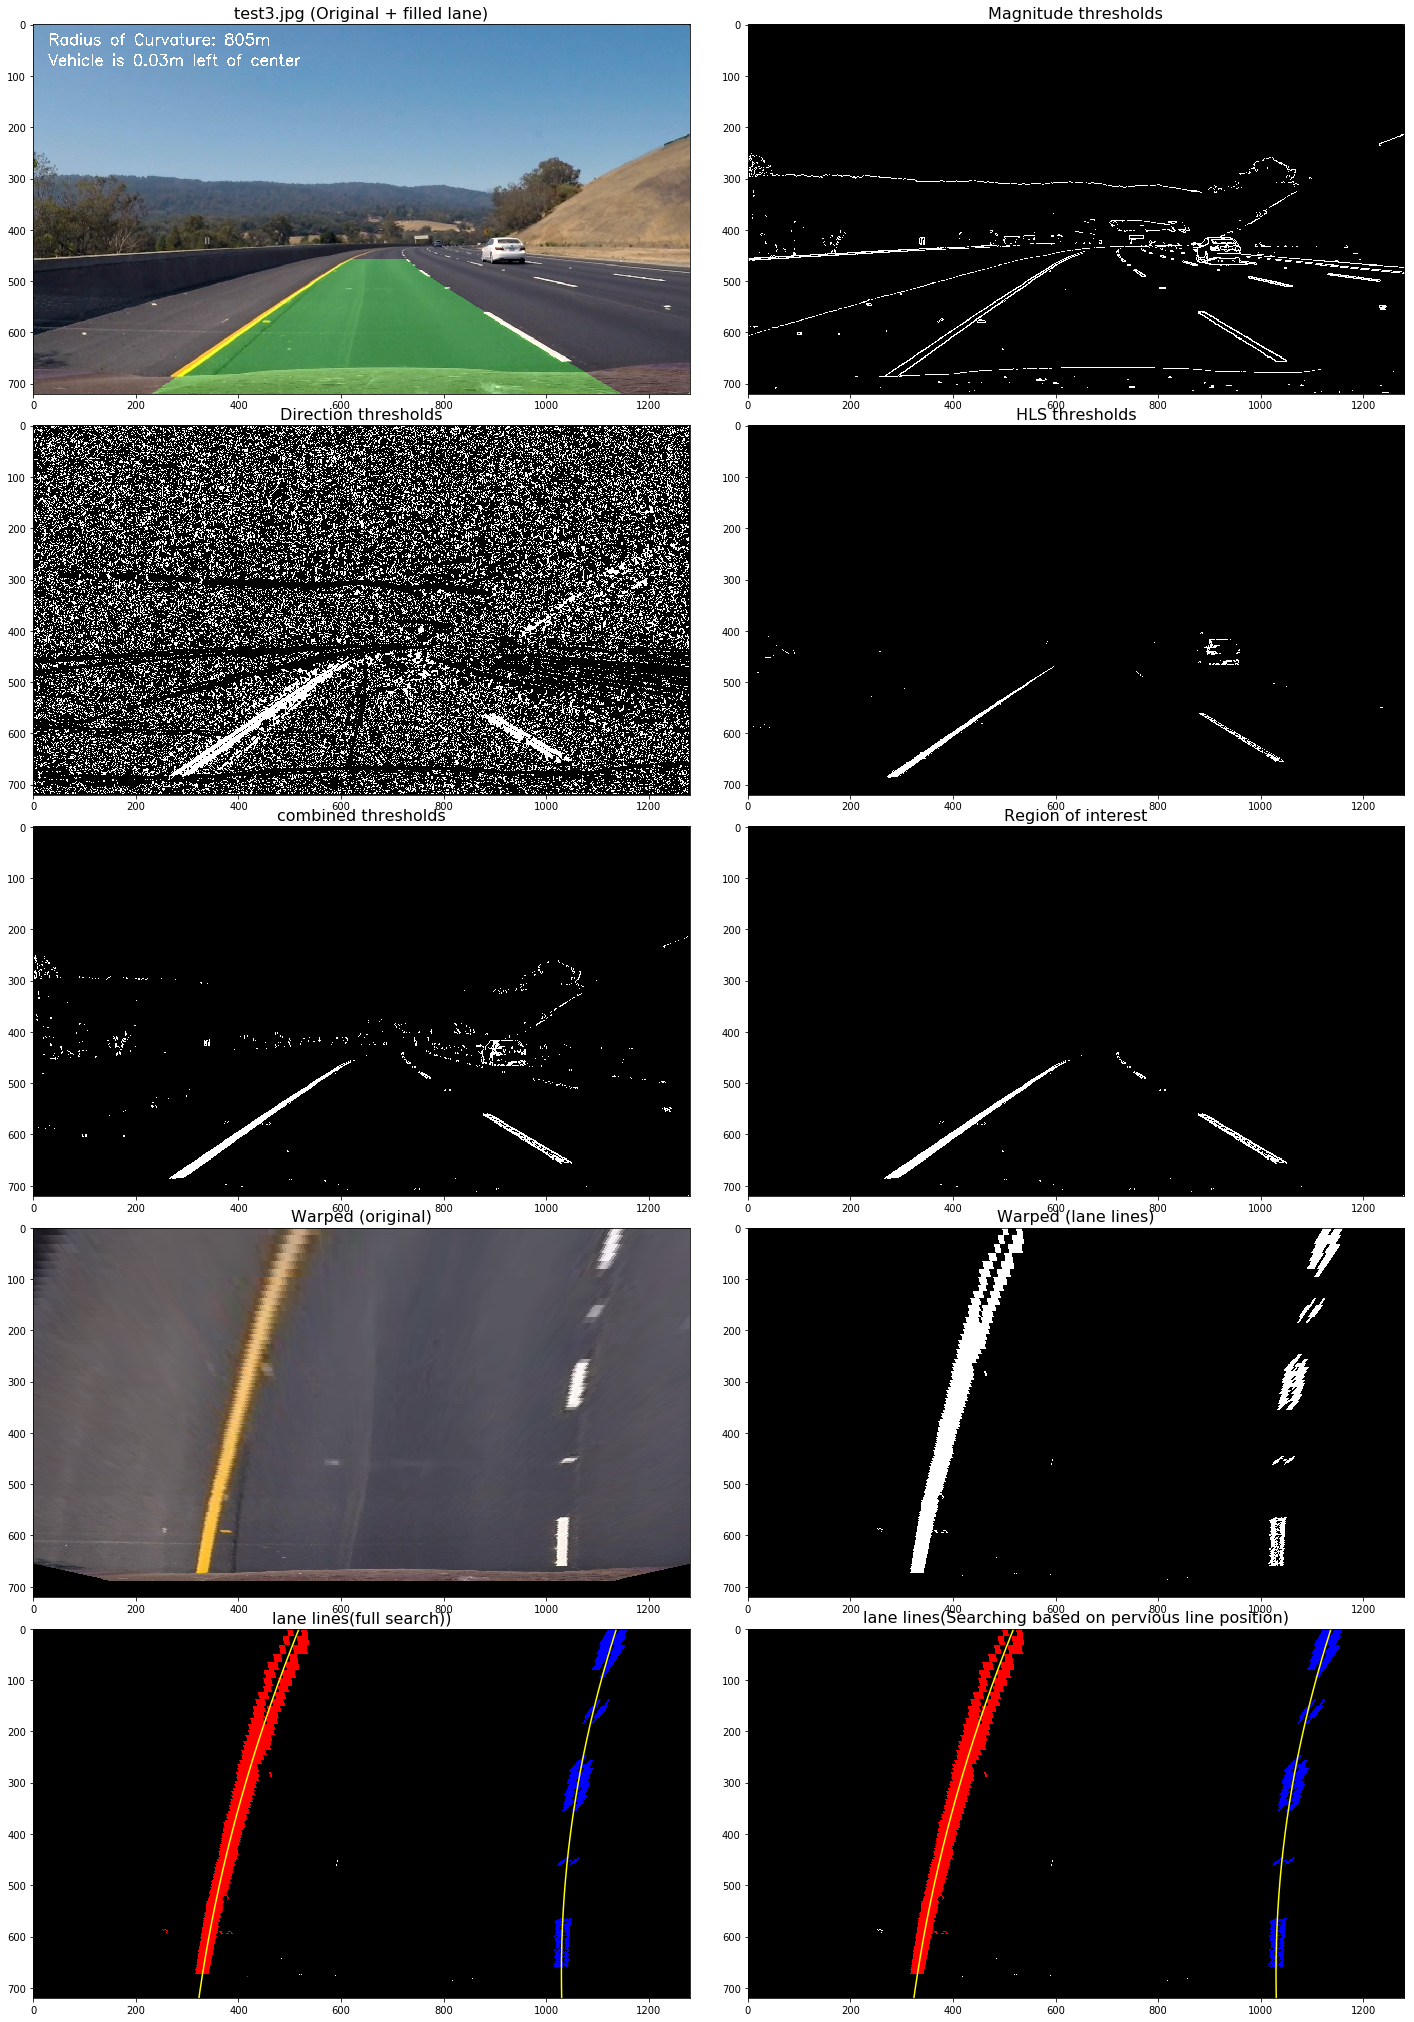

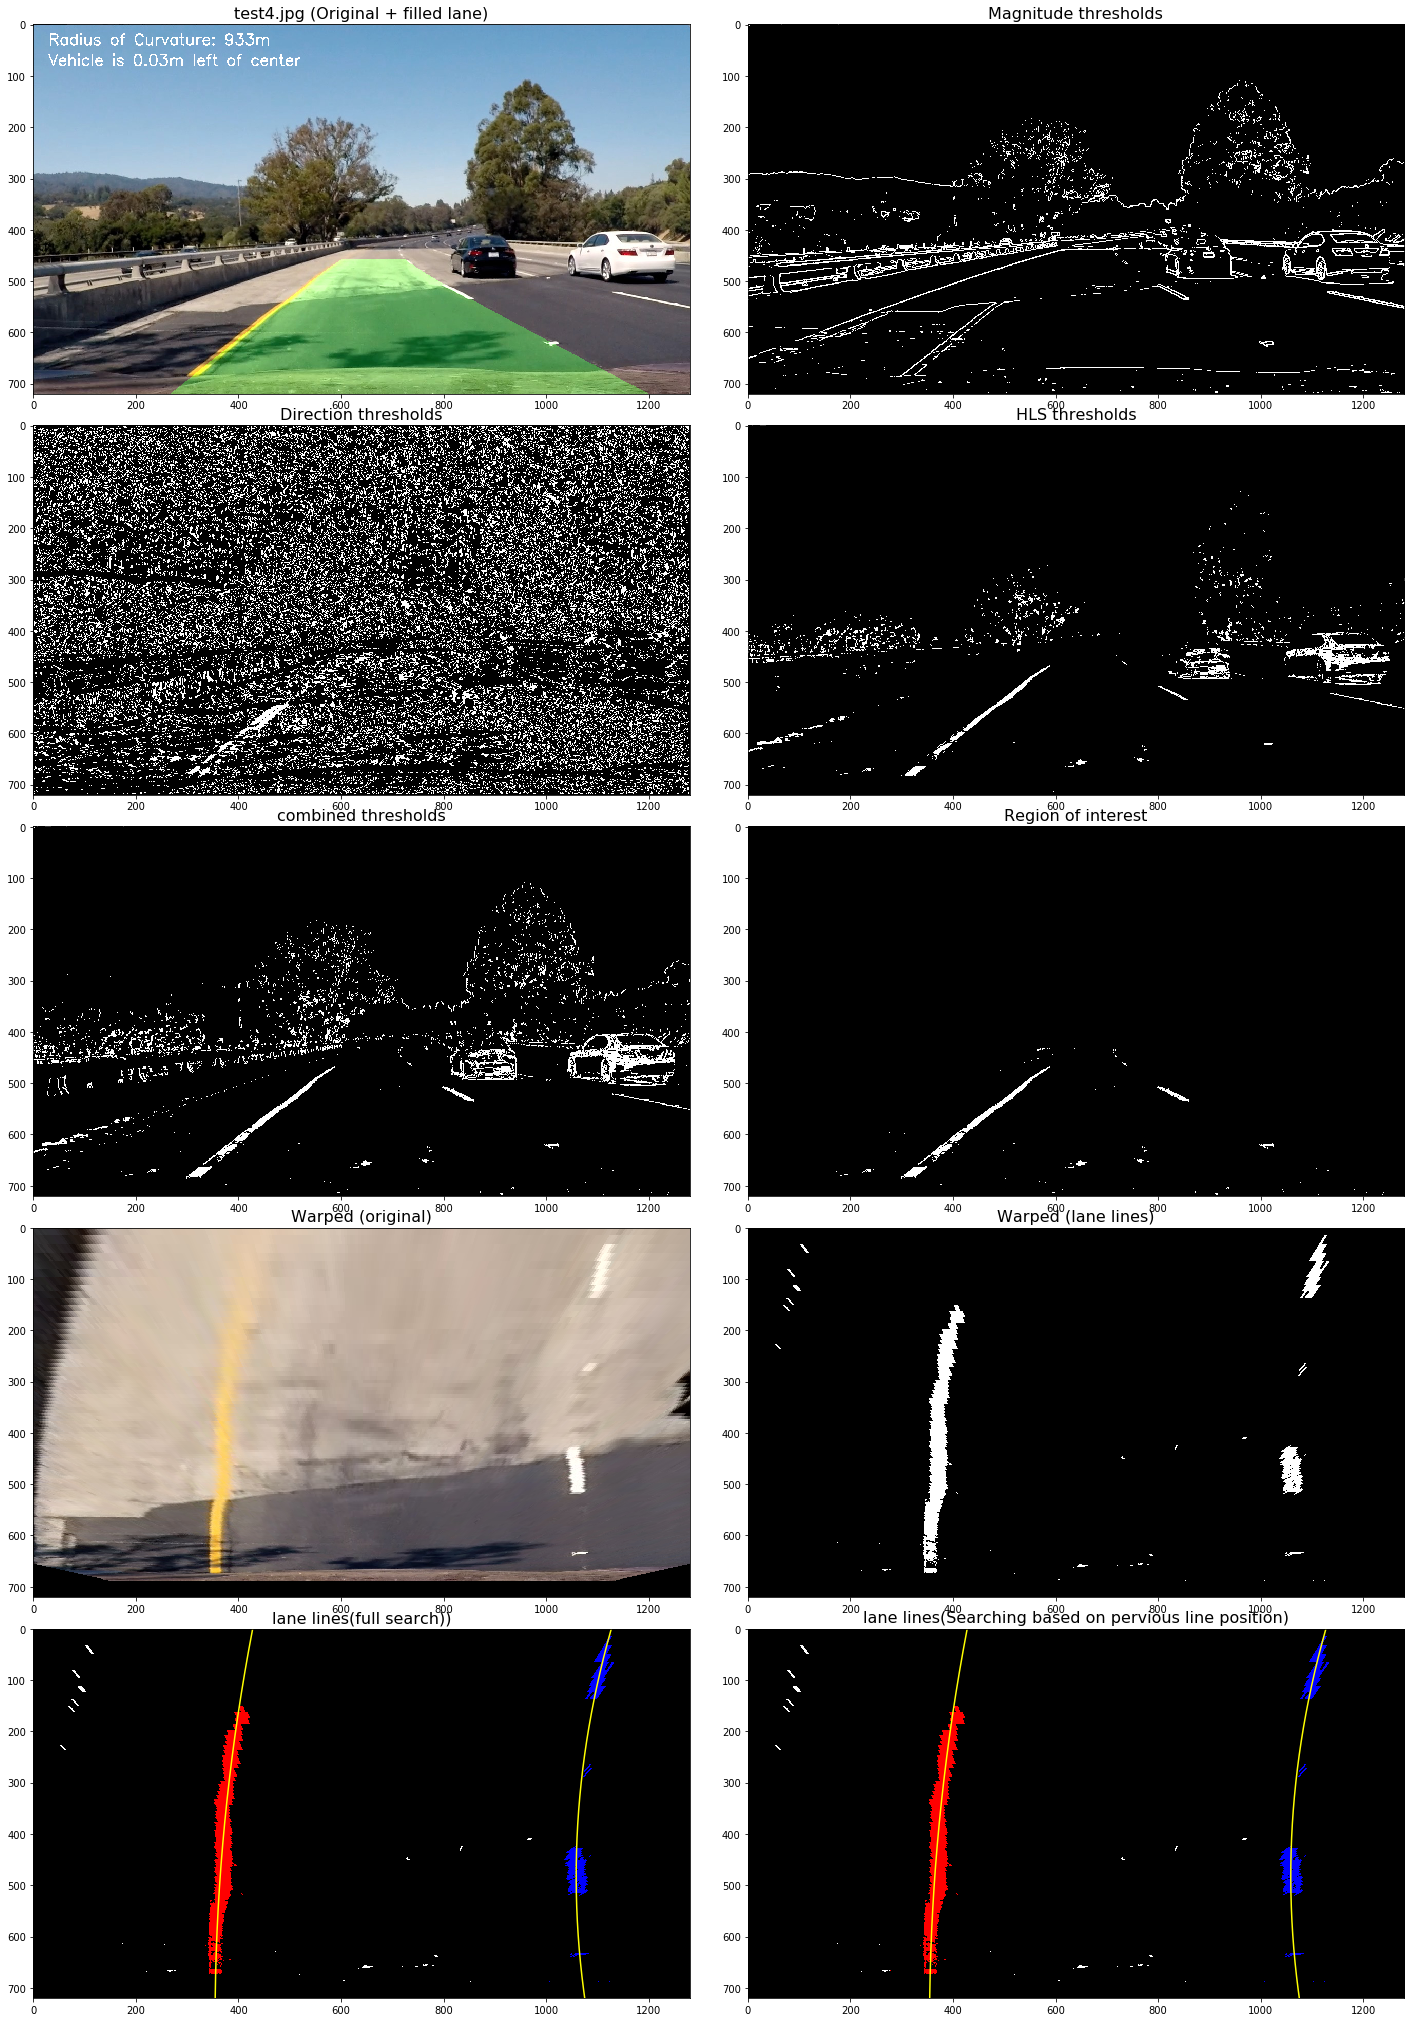

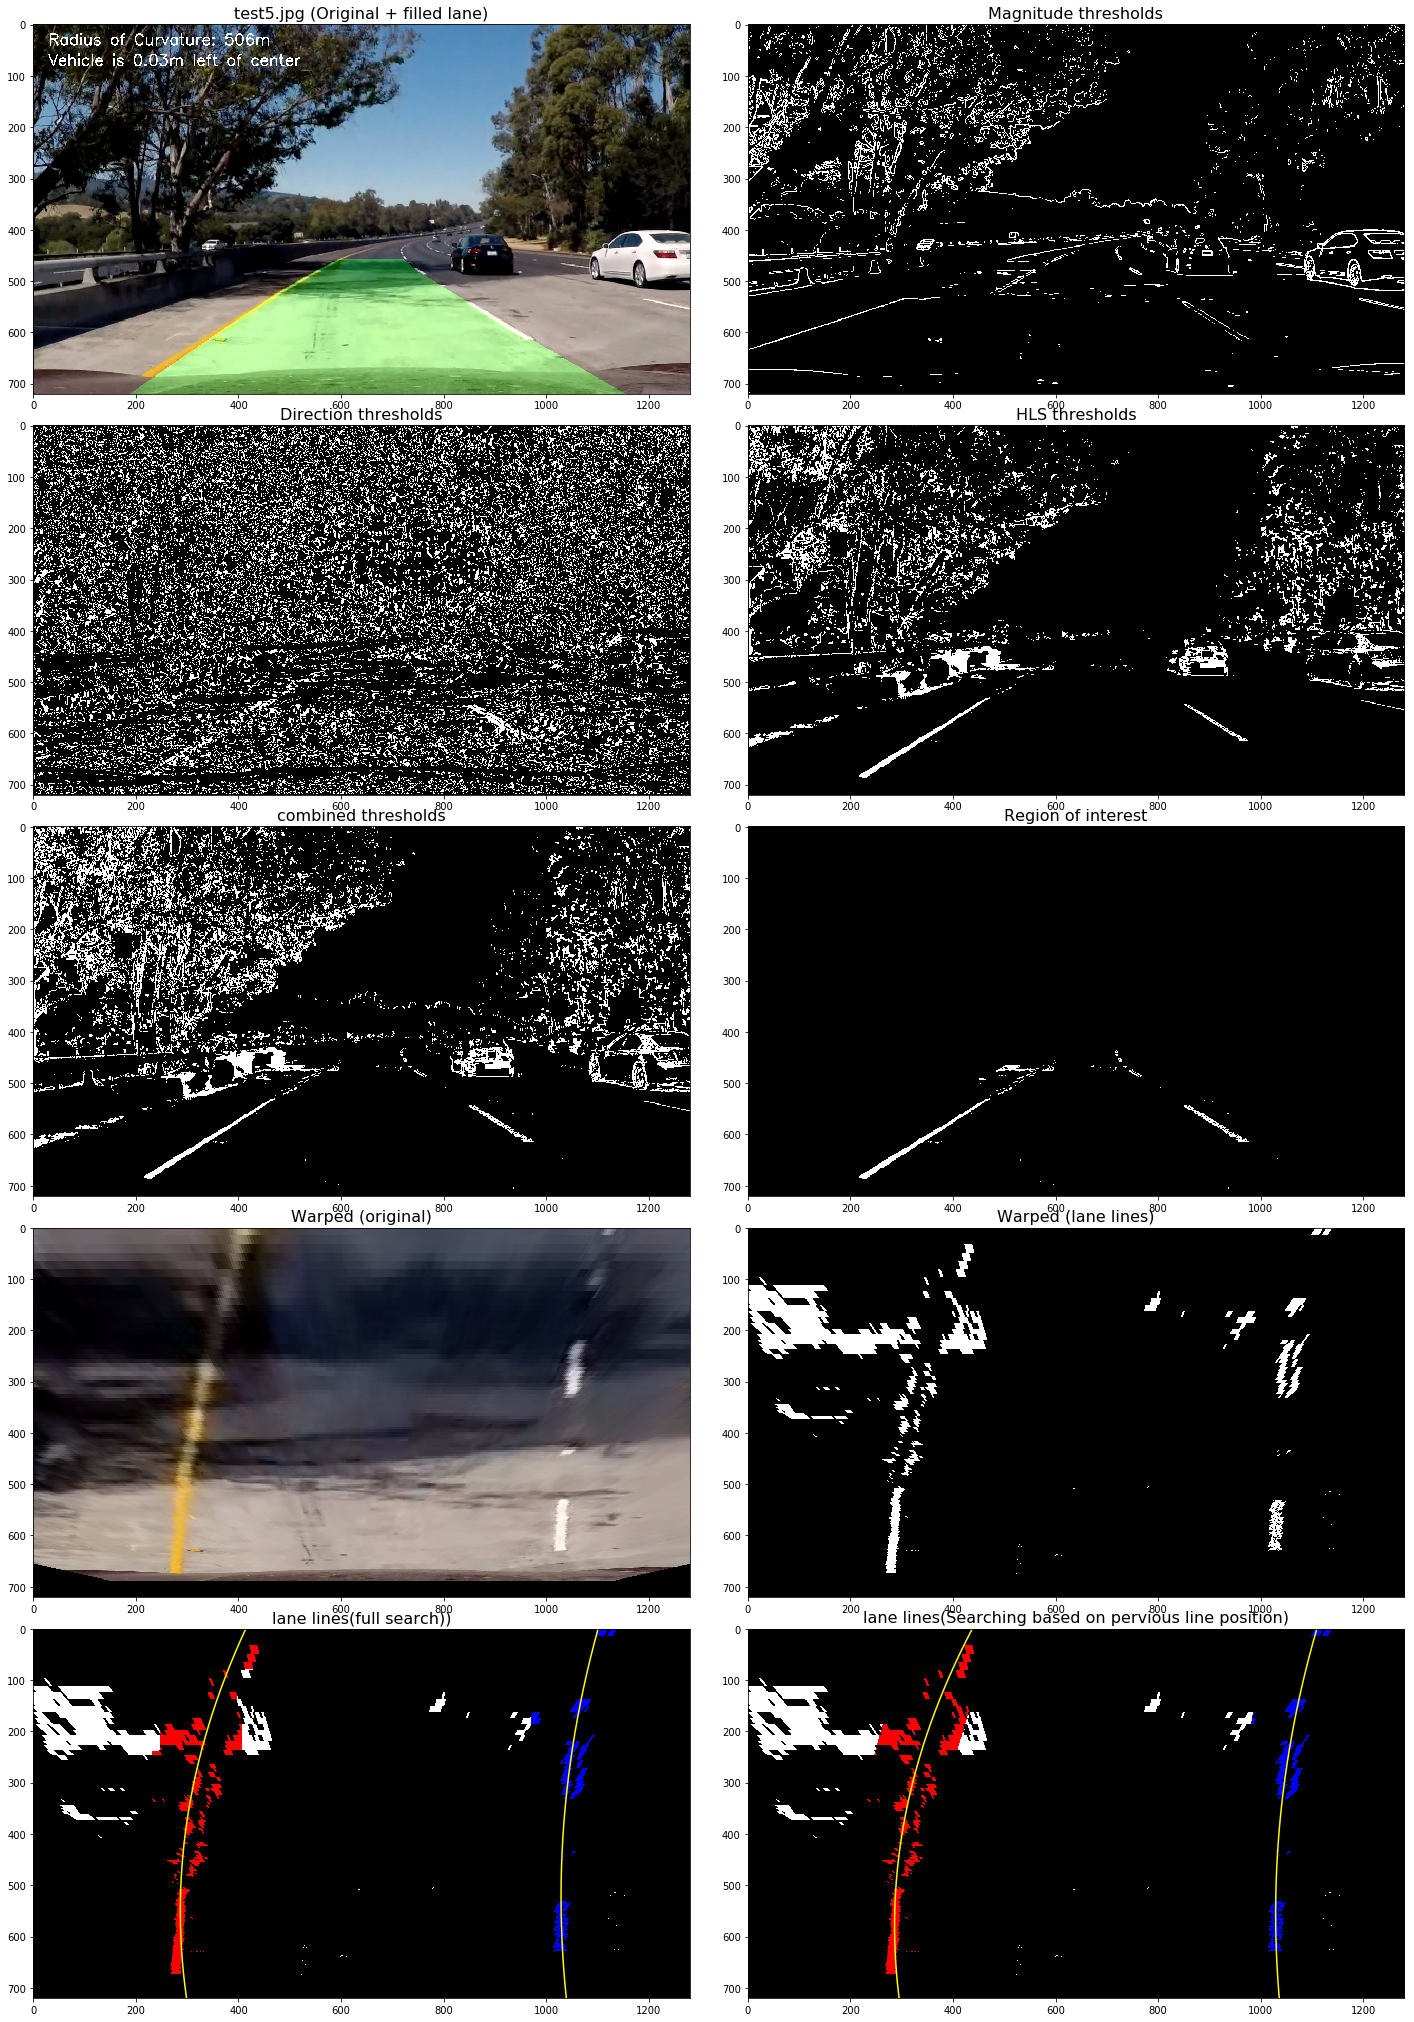

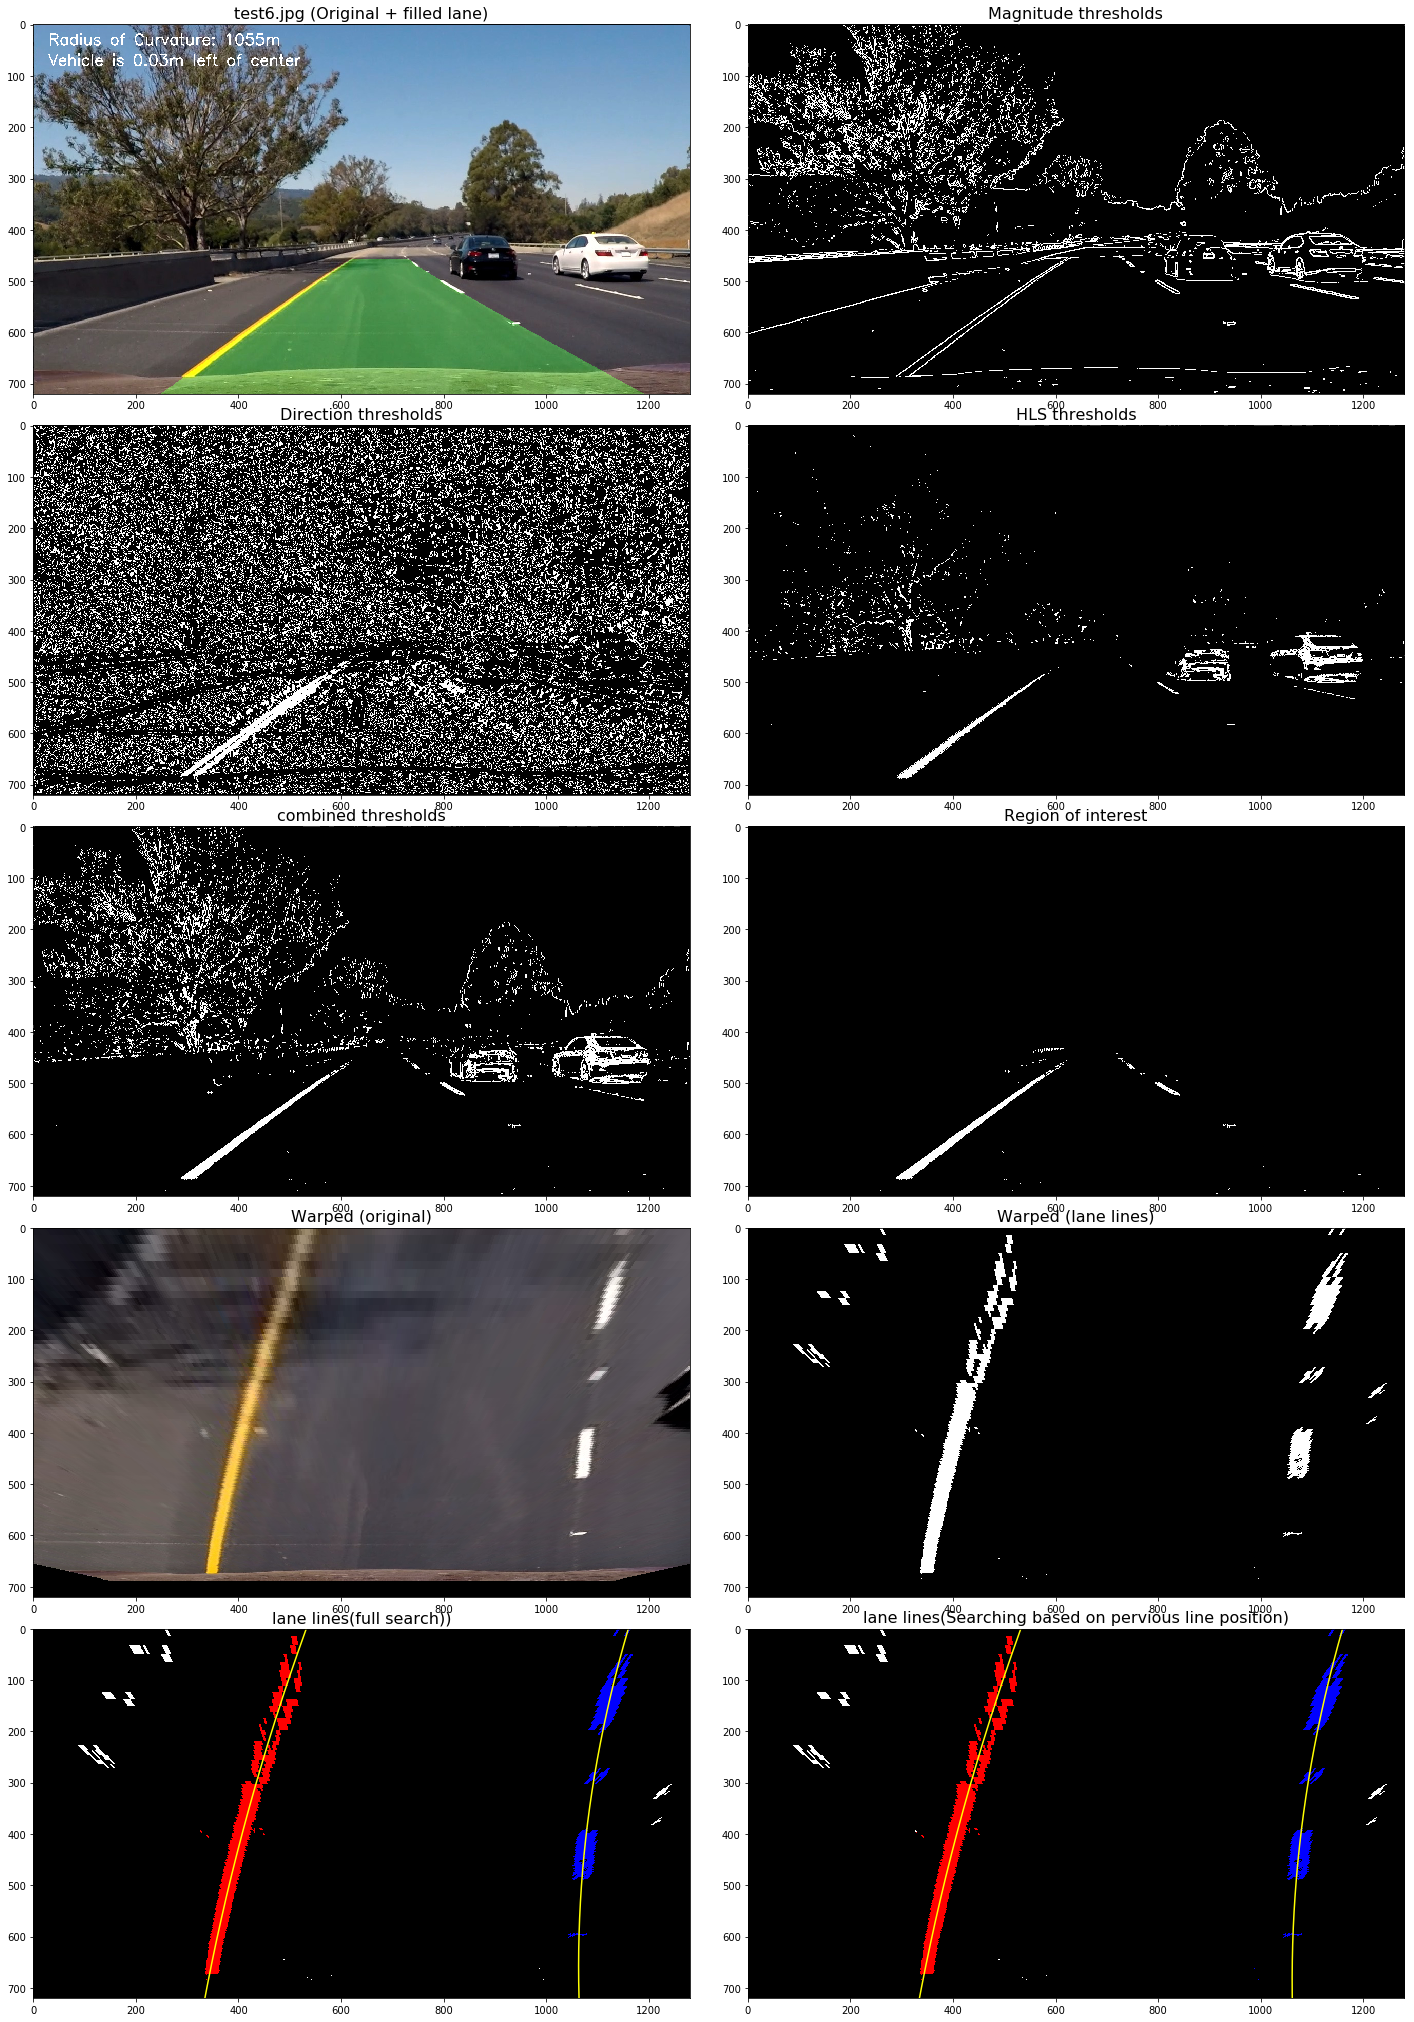

In [151]:
%matplotlib inline

for image_name in testing_names:
    f, axes = plt.subplots(5, 2, figsize=(20, 28))
    f.tight_layout()
    
    image = mpimg.imread('test_images/' + image_name)    
    
    imshape = image.shape
    
    vertices = np.array(
        [[(0,imshape[0]),
        ((int(imshape[1]*4/9)), int(imshape[0]*3/5)), 
        (int((imshape[1]*5/9)), int(imshape[0]*3/5)),
        (imshape[1],imshape[0])]], 
        dtype=np.int32)
    
    lane_lines = (Line(), Line()) # (Left line, right line)
    
    #### Color thresholding
    
    #channel = 'R'
    ##
    #R_gradx = abs_sobel_thresh(image, orient='x', channel=channel, thresh_min=20, thresh_max=255)
    #R_grady = abs_sobel_thresh(image, orient='y', channel=channel, thresh_min=20, thresh_max=255)
    #R_mag_binary = mag_thresh(image, sobel_kernel=3, channel=channel, mag_thresh=(30, 100))
    #R_dir_binary = dir_threshold(image, sobel_kernel=15, channel=channel, thresh=(0.7, 1.1))
    #
    #channel = 'G'
    ##
    #G_gradx = abs_sobel_thresh(image, orient='x', channel=channel, thresh_min=20, thresh_max=255)
    #G_grady = abs_sobel_thresh(image, orient='y', channel=channel, thresh_min=20, thresh_max=255)
    #G_mag_binary = mag_thresh(image, sobel_kernel=3, channel=channel, mag_thresh=(30, 100))
    #G_dir_binary = dir_threshold(image, sobel_kernel=15, channel=channel, thresh=(0.7, 1.1))
    #
    #channel = 'B'
    ##
    #B_gradx = abs_sobel_thresh(image, orient='x', channel=channel, thresh_min=20, thresh_max=255)
    #B_grady = abs_sobel_thresh(image, orient='y', channel=channel, thresh_min=20, thresh_max=255)
    #B_mag_binary = mag_thresh(image, sobel_kernel=3, channel=channel, mag_thresh=(30, 100))
    #B_dir_binary = dir_threshold(image, sobel_kernel=15, channel=channel, thresh=(0.7, 1.1))

    channel = 'gray'
    #
    gray_gradx = abs_sobel_thresh(image, orient='x', channel=channel, thresh_min=50, thresh_max=255)
    gray_grady = abs_sobel_thresh(image, orient='y', channel=channel, thresh_min=20, thresh_max=255)
    gray_mag_binary = mag_thresh(image, sobel_kernel=3, channel=channel, mag_thresh=(50, 255))
    gray_dir_binary = dir_threshold(image, sobel_kernel=15, channel=channel, thresh=(0.7, 1.1))
    
    #### HLS thresholding
    hls_binary = hls_select(image, thresh=(170,255))
    
    #### Combined thresholding
    combined = np.zeros_like(gray_dir_binary)
    #combined[((gray_gradx == 1) & (gray_grady == 1)) | ((gray_mag_binary == 1) & (gray_dir_binary == 1) | (hls_binary == 1))] = 1
    combined[(gray_gradx == 1) | ((gray_mag_binary == 1) & (gray_dir_binary == 1) | (hls_binary == 1))] = 1
    
    #### Region masking
    roi_image = region_of_interest(combined, vertices)
    
    #### Perspective transformtion
    tranform_src = np.float32([[739, 478], [1035 ,662],[284, 662], [549, 478]])
    tranform_dsr = np.float32([[1035-20, 260], [1035-20, 662],[284+20, 662], [284+20, 260]])
    
    image_warped = perspect_transform(image, tranform_src, tranform_dsr)
    binary_warped = perspect_transform(roi_image, tranform_src, tranform_dsr)
    
    #### Finding lane lines (full search)
    margin = 80
    image_fit = np.dstack((binary_warped, binary_warped, binary_warped))
    (lline, rline) = find_lanes_fullsearch(binary_warped, lane_lines, margin)
    
    image_fit[lline.ally, lline.allx] = [1.0, 0, 0]
    image_fit[rline.ally, rline.allx] = [0, 0, 1.0]
    
    # Generate x and y values for plotting
    left_fitx, right_fitx, ploty = polyfit_xyvals(lline.current_fit, rline.current_fit, binary_warped.shape[0])
    
    # fill lane area
    warped_filled_lane = fill_lane(binary_warped, left_fitx, right_fitx, fity)
    unwarped_filled_lane = perspect_transform(warped_filled_lane, tranform_dsr, tranform_src)
    result = cv2.addWeighted(image, 1, unwarped_filled_lane, 0.3, 0)
    
    #### Calculate curvature and position w.r.t. lane center
    left_curverad, right_curverad, lline_base_pos, rline_base_pos = calc_curvature_n_pos(left_fitx, right_fitx, ploty)
    #
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    thickness = 2
    #
    text = "Radius of Curvature: {}m".format(int((left_curverad + right_curverad) / 2))
    cv2.putText(result, text, (30,40), font, font_scale,(255,255,255), thickness)
    #
    base_pos = (lline_base_pos + rline_base_pos)/2
    if base_pos > 0:
        text = "Vehicle is {:.2f}m left of center".format(base_pos)
    else:
        text = "Vehicle is {:.2f}m right of center".format(-base_pos)
    cv2.putText(result, text, (30,80), font, font_scale,(255,255,255), thickness)
        
    fontsize=16
    axes[0,0].imshow(result)
    axes[0,0].set_title(image_name +  ' (Original + filled lane)', fontsize=fontsize)

    axes[0,1].imshow(gray_mag_binary, cmap='gray')
    axes[0,1].set_title('Magnitude thresholds', fontsize=fontsize)
    
    axes[1,0].imshow(gray_dir_binary, cmap='gray')
    axes[1,0].set_title('Direction thresholds', fontsize=fontsize)
    
    axes[1,1].imshow(hls_binary, cmap='gray')
    axes[1,1].set_title('HLS thresholds', fontsize=fontsize)
    
    axes[2,0].imshow(combined, cmap='gray')
    axes[2,0].set_title('combined thresholds', fontsize=fontsize)
    
    axes[2,1].imshow(roi_image, cmap='gray')
    axes[2,1].set_title('Region of interest', fontsize=fontsize)
    
    axes[3,0].imshow(image_warped)
    axes[3,0].set_title('Warped (original)', fontsize=fontsize)
    
    axes[3,1].imshow(binary_warped, cmap='gray')
    axes[3,1].set_title('Warped (lane lines)', fontsize=fontsize)
        
    axes[4,0].imshow(image_fit)
    axes[4,0].plot(left_fitx, ploty, color='yellow')
    axes[4,0].plot(right_fitx, ploty, color='yellow')    
    axes[4,0].set_title('lane lines(full search))', fontsize=fontsize)

    
    #### Finding lane lines (polyfit)
    image_fit = np.dstack((binary_warped, binary_warped, binary_warped))
    (lline, rline) = find_lanes_polyfit(binary_warped, lane_lines, margin)

    image_fit[lline.ally, lline.allx] = [1.0, 0, 0]
    image_fit[rline.ally, rline.allx] = [0, 0, 1.0]
    
    # Generate x and y values for plotting
    left_fitx, right_fitx, fity = polyfit_xyvals(lline.current_fit, rline.current_fit, binary_warped.shape[0])
    
    axes[4,1].imshow(image_fit)
    axes[4,1].plot(left_fitx, ploty, color='yellow')
    axes[4,1].plot(right_fitx, ploty, color='yellow')    
    axes[4,1].set_title('lane lines(Searching based on pervious line position)', fontsize=fontsize)
    
    plt.show()
    

## Test on Videos

In [152]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [153]:
def process_image(image):
    
    imshape = image.shape
    
    vertices = np.array(
        [[(0,imshape[0]),
        ((int(imshape[1]*4/9)), int(imshape[0]*3/5)), 
        (int((imshape[1]*5/9)), int(imshape[0]*3/5)),
        (imshape[1],imshape[0])]], 
        dtype=np.int32)
    
    (lline, rline) = lane_lines # (left line, right line)
    
    channel = 'gray'
    #
    gray_gradx = abs_sobel_thresh(image, orient='x', channel=channel, thresh_min=50, thresh_max=255)
    gray_grady = abs_sobel_thresh(image, orient='y', channel=channel, thresh_min=20, thresh_max=255)
    gray_mag_binary = mag_thresh(image, sobel_kernel=3, channel=channel, mag_thresh=(50, 255))
    gray_dir_binary = dir_threshold(image, sobel_kernel=15, channel=channel, thresh=(0.7, 1.1))
    
    #### HLS thresholding
    hls_binary = hls_select(image, thresh=(170,255))
    
    #### Combined thresholding
    combined = np.zeros_like(gray_dir_binary)
    combined[(gray_gradx == 1) | ((gray_mag_binary == 1) & (gray_dir_binary == 1) | (hls_binary == 1))] = 1
    
    #### Region masking
    roi_image = region_of_interest(combined, vertices)
    
    #### Perspective transformtion
    tranform_src = np.float32([[739, 478], [1035 ,662],[284, 662], [549, 478]])
    tranform_dsr = np.float32([[1035-20, 260], [1035-20, 662],[284+20, 662], [284+20, 260]])
    
    binary_warped = perspect_transform(roi_image, tranform_src, tranform_dsr)
    
    #### Finding lane lines (full search)
    margin = 80
    if (lline.detected == False) or (rline.detected == False):
        (lline, rline) = find_lanes_fullsearch(binary_warped, lane_lines, margin)
    else:
        (lline, rline) = find_lanes_polyfit(binary_warped, lane_lines, margin)
    
    # Generate x and y values for plotting
    left_fitx, right_fitx, fity = polyfit_xyvals(lline.current_fit, rline.current_fit, binary_warped.shape[0])
    
    # fill lane area
    warped_filled_lane = fill_lane(binary_warped, left_fitx, right_fitx, fity)
    unwarped_filled_lane = perspect_transform(warped_filled_lane, tranform_dsr, tranform_src)
    result = cv2.addWeighted(image, 1, unwarped_filled_lane, 0.3, 0)
    
    #### Calculate curvature and position w.r.t. lane center
    left_curverad, right_curverad, lline_base_pos, rline_base_pos = calc_curvature_n_pos(left_fitx, right_fitx, ploty)
    #
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    thickness = 2
    #
    text = "Radius of Curvature: {}m".format(int((left_curverad + right_curverad) / 2))
    cv2.putText(result, text, (30,40), font, font_scale,(255,255,255), thickness)
    #
    base_pos = (lline_base_pos + rline_base_pos)/2
    if base_pos > 0:
        text = "Vehicle is {:.2f}m left of center".format(base_pos)
    else:
        text = "Vehicle is {:.2f}m right of center".format(-base_pos)
    cv2.putText(result, text, (30,80), font, font_scale,(255,255,255), thickness)
    
    return result

In [154]:
lane_lines = (Line(), Line()) # (left line, right line)

project_output = 'output_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image)
%time project_clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:32<00:00,  4.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

Wall time: 4min 32s


In [155]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))